## Prerequisites

The following notebook is guiding you through a creation of a basic (but performative) Wake Word model 
using a "STOP" word is a trigger with CNN and binary crossentropy as a loss function.
I decided to go with something robust that will definitely work, also if I will have some time I will try to update 
a solution with a LSTM + CTC loss implementation, but for streaming transformers using LSTM and CTC for now are mostly 
described in Amazon and Google recent publications (February 2021), so implementation from article from a scratch 
receiving good results might take more than a week, hence this working solution might be a good start.
For the training set the Google Commands v1 was used.

The model was trained in AWS SageMaker using Tensorflow 2.3 and Python 3.7, 4vCPUS + 1 GPU and CUDA, however, there is no backwards compatibility with this TF version for cudnn, so I had to downgrade TF to tensorflow-gpu==1.15.

To run the notebook in Debian (Ubuntu), there is also a need to install additional libraries and update repositories.
If desired to run in a Docker image from SageMaker, there is a need to run following commands:
#####  ~ apt update
#####  ~ apt install libsndfile #a library to proceed audiosignals
#####  ~ pip install librosa
#####  ~ pip install matplotlib
#####  ~ pip install python_speech_features #additional library to manipulate MFCCs

The used SageMaker docker image already has Python 3.7, Tensorflow, Keras, Pandas and Numpy installed.

The notebook contains following parts:
1. Data preparation and validation
2. MFCC extraction 
3. Model architecture definition
4. Model training
5. Metrics

The model can be converted to *.tflite format and then deployed to Raspberry Pi (since we're dealing with developing systems for a hardware), but at this point the model conversion and code for the deployment was omitted. Nevertheless, it is possible to perform these actions. 

In [2]:
# Import libraries
from os import listdir
from os.path import isdir, join
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt
import python_speech_features
from tensorflow.keras import layers, models

In [44]:
# Data collection
#!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz
#mkdir data
#tar -xzvf speech_commands_v0.01.tar.gz data, takes around 30 minutes

--2021-08-18 14:32:00--  https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.208, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  95.0MB/s    in 14s     

2021-08-18 14:32:27 (101 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [3]:
# Dataset path and view possible targets
# Here we are checking the directories list for the demonstration and hierarchy exploration purpose
dataset_path = 'data'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

tree
zero
down
three
cat
six
house
four
one
happy
five
nine
two
dog
go
stop
sheila
right
bird
yes
eight
seven
up
marvin
on
wow
no
left
bed
off
_background_noise_


In [4]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['tree', 'zero', 'down', 'three', 'cat', 'six', 'house', 'four', 'one', 'happy', 'five', 'nine', 'two', 'dog', 'go', 'stop', 'sheila', 'right', 'bird', 'yes', 'eight', 'seven', 'up', 'marvin', 'on', 'wow', 'no', 'left', 'bed', 'off', '_background_noise_']


In [5]:
# Remove background noise set since we don't want to include a background noise to be used in training this time
all_targets.remove('_background_noise_')
print(all_targets)

['tree', 'zero', 'down', 'three', 'cat', 'six', 'house', 'four', 'one', 'happy', 'five', 'nine', 'two', 'dog', 'go', 'stop', 'sheila', 'right', 'bird', 'yes', 'eight', 'seven', 'up', 'marvin', 'on', 'wow', 'no', 'left', 'bed', 'off']


In [6]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1733
2376
2359
2356
1733
2369
1750
2372
2370
1742
2357
2364
2373
1746
2372
2380
1734
2367
1731
2377
2352
2377
2375
1746
2367
1745
2375
2353
1713
2357
Total samples: 64721


In [7]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz' #to save an extracted MFCCs as a separate file after the processing; 
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1 #validation ratio
test_ratio = 0.1 #testing ratio
sample_rate = 8000 #define a sample rate
num_mfcc = 16 # we are creating an array of 16 x 16 from the features, in ASR most of the MFCC features used for the development are lie in range (0:8 - 0:20)
len_mfcc = 16 #and the number was picked empirically after exploring the MFCC of the word "STOP" where the representation of the MEL is lying around the 16.

In [8]:
# Create list of filenames along with ground truth vector (y) for the convenience of the future use
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

data/tree
data/zero
data/down
data/three
data/cat
data/six
data/house
data/four
data/one
data/happy
data/five
data/nine
data/two
data/dog
data/go
data/stop
data/sheila
data/right
data/bird
data/yes
data/eight
data/seven
data/up
data/marvin
data/on
data/wow
data/no
data/left
data/bed
data/off


In [9]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [10]:
# Flatten filename and y vectors, so we don't need to deal with multidimensional tensors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [11]:
# Associate filenames with true output and shuffle to get a proper data for the training
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [12]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

64721
64721


In [13]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [14]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [15]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [16]:
#Create MFCC from given path
# We don't need to add RIFF headers, simply using python_speech_features library and librosa.
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs, #keep 8000
                                            winlen=0.256, #the length of the analysis window in seconds, 256 miliseconds
                                            winstep=0.050,#the step between succesive window in seconds, 50 ms
                                            numcep=num_mfcc,#the number of cepstrum to return, using the same number
                                            nfilt=26,#number of filters in filterbank, default value
                                            nfft=2048,#the Fast Fourier Transform, adapted to winlen, empirically
                                            preemph=0.0,#no need for preemphasis filter
                                            ceplifter=0,#no need to lift cepstrals
                                            appendEnergy=False,#no need to replace coefficients with the log of total frame energy
                                            winfunc=np.hanning) #symmetric window to call in FFT
    return mfccs.transpose()

In [17]:
#Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500, since we have a big dataset and need to check how many samples are actually don't fit into the training
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape) #Since we specified the dimension of 16 x 16 for the ease of running, check the shape of MFCCs given and drop those that will not be used
        prob_cnt += 1

Dropped: 19 (16, 14)
Dropped: 23 (16, 11)
Dropped: 43 (16, 14)
Dropped: 54 (16, 14)
Dropped: 57 (16, 14)
Dropped: 94 (16, 12)
Dropped: 100 (16, 13)
Dropped: 148 (16, 15)
Dropped: 151 (16, 15)
Dropped: 161 (16, 15)
Dropped: 165 (16, 15)
Dropped: 168 (16, 13)
Dropped: 171 (16, 13)
Dropped: 195 (16, 11)
Dropped: 202 (16, 15)
Dropped: 223 (16, 15)
Dropped: 230 (16, 15)
Dropped: 238 (16, 13)
Dropped: 243 (16, 10)
Dropped: 247 (16, 9)
Dropped: 250 (16, 13)
Dropped: 274 (16, 15)
Dropped: 276 (16, 14)
Dropped: 283 (16, 10)
Dropped: 286 (16, 13)
Dropped: 300 (16, 8)
Dropped: 316 (16, 11)
Dropped: 326 (16, 13)
Dropped: 339 (16, 13)
Dropped: 347 (16, 13)
Dropped: 350 (16, 10)
Dropped: 352 (16, 9)
Dropped: 353 (16, 11)
Dropped: 362 (16, 15)
Dropped: 387 (16, 13)
Dropped: 412 (16, 10)
Dropped: 422 (16, 10)
Dropped: 437 (16, 11)
Dropped: 443 (16, 15)
Dropped: 493 (16, 14)


In [43]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.086


MFCCs: [[-7.10925502e+01 -7.21021976e+01 -7.24483369e+01 -7.30202638e+01
  -7.26694722e+01 -7.25550821e+01 -7.32061561e+01 -7.39421375e+01
  -5.60731537e+01 -3.57971641e+01 -2.63366072e+01 -2.38200521e+01
  -2.64224589e+01 -3.31482452e+01 -4.26188690e+01 -5.23958913e+01]
 [ 1.28761868e+01  1.16029021e+01  1.24814442e+01  1.30161411e+01
   1.49840015e+01  1.59473589e+01  1.44952366e+01  1.12947001e+01
   8.34718691e+00  1.31177582e+01  1.49787290e+01  1.62611866e+01
   1.74804156e+01  1.86844384e+01  1.96194676e+01  2.05805051e+01]
 [ 9.84866383e+00  8.63745278e+00  8.38020308e+00  8.45859137e+00
   9.82259627e+00  1.00634344e+01  8.76286685e+00  5.34872167e+00
   1.67357595e+00  7.64744632e-01 -8.98702603e-02 -5.16937847e-01
  -5.99825813e-01 -1.25965300e-02  1.63658620e+00  2.56267466e+00]
 [ 7.80969276e+00  6.73613103e+00  6.57294278e+00  6.47399284e+00
   7.03269994e+00  7.07117702e+00  6.41128464e+00  5.06205169e+00
   6.19921641e+00  4.14027028e+00  2.88572559e+00  1.96581036e+00


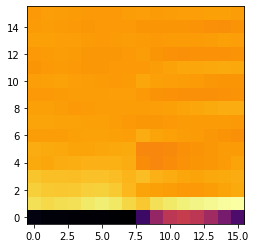

In [47]:
#Test shorter MFCC
#!pip install playsound if needed to play the object 
#!pip install pygobject additional requirement for the playsound
from playsound import playsound

idx = 13 #word "go"

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path) - to play the sound

As seen on the plot, this word doesn't actually fit into the requested shape.

In [19]:
#Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets, takes around 20 mins with 4vCPUS + 1GPU
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 19 (16, 14)
Dropped: 23 (16, 11)
Dropped: 43 (16, 14)
Dropped: 54 (16, 14)
Dropped: 57 (16, 14)
Dropped: 94 (16, 12)
Dropped: 100 (16, 13)
Dropped: 148 (16, 15)
Dropped: 151 (16, 15)
Dropped: 161 (16, 15)
Dropped: 165 (16, 15)
Dropped: 168 (16, 13)
Dropped: 171 (16, 13)
Dropped: 195 (16, 11)
Dropped: 202 (16, 15)
Dropped: 223 (16, 15)
Dropped: 230 (16, 15)
Dropped: 238 (16, 13)
Dropped: 243 (16, 10)
Dropped: 247 (16, 9)
Dropped: 250 (16, 13)
Dropped: 274 (16, 15)
Dropped: 276 (16, 14)
Dropped: 283 (16, 10)
Dropped: 286 (16, 13)
Dropped: 300 (16, 8)
Dropped: 316 (16, 11)
Dropped: 326 (16, 13)
Dropped: 339 (16, 13)
Dropped: 347 (16, 13)
Dropped: 350 (16, 10)
Dropped: 352 (16, 9)
Dropped: 353 (16, 11)
Dropped: 362 (16, 15)
Dropped: 387 (16, 13)
Dropped: 412 (16, 10)
Dropped: 422 (16, 10)
Dropped: 437 (16, 11)
Dropped: 443 (16, 15)
Dropped: 493 (16, 14)
Dropped: 500 (16, 12)
Dropped: 504 (16, 15)
Dropped: 508 (16, 10)
Dropped: 512 (16, 15)
Dropped: 530 (16, 13)
Dropped: 544 (16, 9

In [50]:
# Save features and truth vector (y) sets to disk to make a backup
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [51]:
#Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files


['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [52]:
#check length of the feature sets
len(feature_sets['x_train'])

47600

In [53]:
print(feature_sets['y_val'])

[ 8.  3.  6. ... 28.  7. 15.]


In [21]:
# Pre-train config
feature_sets_path = 'feature_sets'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop' #determine a trigger word

In [22]:
# Load feature sets
import numpy as np
from os import listdir
from os.path import isdir, join

all_targets = [name for name in listdir('data') if isdir(join('data', name))]

feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [23]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [24]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#Looks good, no ambiguous shapes

(47600, 16, 16)
(5960, 16, 16)
(5938, 16, 16)


In [25]:
# Peek at labels
print(y_val)

[ 8.  3.  6. ... 28.  7. 15.]


In [26]:
# Convert ground truth arrays to one wake word (1) and 'other' (0) since we need to distinguish between "stop" and "not stop"
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [27]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 1.]


In [28]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.0348993288590604
0.9651006711409396


In [29]:
# View the dimensions of our input data
print(x_train.shape)

(47600, 16, 16)


In [30]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(47600, 16, 16, 1)
(5960, 16, 16, 1)
(5938, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# A CNN contains 2 parts: convolutional section and a classification section
#Used a simple and proven architecture to achieve a baseline
#Convolution refers to filtering the spectrogram to identify the features in the given image
model = models.Sequential()
model.add(layers.Conv2D(32, #use 32 nodes
                        (2, 2), 
                        activation='relu', #converts any negative values to 0 to add a level of non-linearity to a NN for classification purpose
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Another window slides across each filtered spectrogram to keep most
                                                 #important features about the hughest pixel value location and 
                                                 #to reduce a computational load for the next layers

#repeat
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu')) #Trained 2 times, hence we have a set of 64 feature nodes maps to train on
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten()) #Rather than being a collection of 2D matrices, flatten to big vector
model.add(layers.Dense(64, activation='relu')) #One layer with 64 nodes, again ReLU
model.add(layers.Dropout(0.5)) # 50% of the node outputs from the previous layer are randomly ignored going into the next layer
model.add(layers.Dense(1, activation='sigmoid')) #will give us a number between 0 and 1 that corresponds to the confidence the model has


In [14]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [15]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', #specifically designed to help train models for binary classification.
              optimizer='rmsprop', 
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Train on 47600 samples, validate on 5960 samples
Epoch 1/30
47600/47600 [==============================] - 10s 220us/sample - loss: 0.1285 - acc: 0.9639 - val_loss: 0.0830 - val_acc: 0.9705
Epoch 2/30
47600/47600 [==============================] - 2s 35us/sample - loss: 0.0892 - acc: 0.9709 - val_loss: 0.0655 - val_acc: 0.9819
Epoch 3/30
47600/47600 [==============================] - 2s 34us/sample - loss: 0.0759 - acc: 0.9759 - val_loss: 0.0606 - val_acc: 0.9815
Epoch 4/30
47600/47600 [==============================] - 2s 35us/sample - loss: 0.0668 - acc: 0.9786 - val_loss: 0.0535 - val_acc: 0.9839
Epoch 5/30
47600/47600 [==============================] - 2s 34us/sample - loss: 0.0620 - acc: 0.9815 - val_loss: 0.0521 - val_acc: 0.9854
Epoch 6/30
47600/47600 [==============================] - 2s 34us/sample - loss: 0.0584 - acc: 0.9817 - val_loss: 0.0513 - val_acc: 0.9864
Epoch 7/30
47600/47600 [==============================] - 2s 34us/sample - loss: 0.0544 - acc: 0.9835 - val_loss: 0

  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


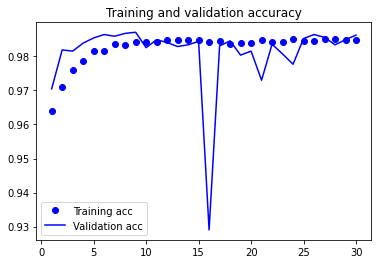

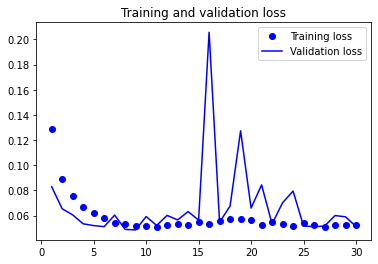

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

On the training plot it seems that the model should be overfitted based on the peaks of the validation loss, but also by the end of the training the loss function is getting closer to the training loss, so here there is a possibility to tackle the model hyperparameters.

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

14
16
37
50
81
113
119
129
157
159
172
177
293
296
382
408
415
486
524
566
574
587
635
651
691
774
790
817
871
877
903
909
952
970
986
1064
1080
1081
1100
1131
1145
1221
1236
1279
1291
1294
1305
1354
1381
1429
1435
1446
1462
1512
1531
1536
1572
1604
1806
1812
1827
1849
1858
1892
1936
1942
1946
1952
1963
1968
1977
2007
2014
2020
2026
2031
2067
2080
2084
2097
2134
2151
2228
2336
2353
2374
2394
2395
2402
2460
2489
2498
2533
2547
2562
2569
2673
2686
2692
2710
2756
2793
2866
2904
2916
2917
2924
2934
2971
2973
2993
3001
3024
3048
3063
3079
3099
3205
3219
3242
3251
3338
3341
3357
3450
3473
3510
3511
3610
3612
3653
3654
3669
3673
3692
3711
3789
3817
3819
3850
3896
3905
3913
3937
3968
4015
4018
4030
4033
4056
4083
4115
4124
4184
4185
4222
4261
4285
4288
4300
4355
4369
4376
4402
4456
4469
4546
4557
4561
4565
4573
4574
4588
4594
4596
4598
4613
4686
4716
4726
4853
4893
4900
4911
4938
4967
4981
5033
5058
5089
5094
5120
5182
5189
5210
5216
5254
5269
5312
5335
5337
5345
5370
5407
5409
5432
5442
5460


In [31]:
# TEST: Load model and run it against test set
model = models.load_model('wake_word_stop_model.h5')
#model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Answer: 0.0  Prediction: [[0.]]
Answer: 0.0  Prediction: [[0.]]
Answer: 0.0  Prediction: [[0.04650298]]
Answer: 0.0  Prediction: [[0.03260007]]
Answer: 0.0  Prediction: [[5.091313e-05]]
Answer: 0.0  Prediction: [[0.]]
Answer: 0.0  Prediction: [[6.4482365e-06]]
Answer: 0.0  Prediction: [[4.4341115e-05]]
Answer: 0.0  Prediction: [[4.277601e-06]]
Answer: 0.0  Prediction: [[0.]]


In [32]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

5938/5938 [==============================] - 0s 64us/sample - loss: 0.0654 - acc: 0.9837


[0.06541780109687292, 0.9836645]

Seems like the model has 98% accuracy, which is pretty good.

In [61]:
# Getting more metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [62]:
preds = np.round(model.predict(x_test),0)

In [186]:
targets = ['0', '1']
classification_metrics = metrics.classification_report(y_test, preds, target_names=targets)

In [187]:
#Build a classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5709
           1       0.93      0.62      0.75       229

    accuracy                           0.98      5938
   macro avg       0.96      0.81      0.87      5938
weighted avg       0.98      0.98      0.98      5938



In [67]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

In [154]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j])) 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

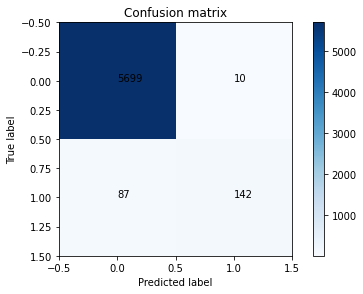

In [155]:
plot_confusion_matrix(cm, classes='targets')

5699 predictions were true negatives,
142 were true positives,
10 were false positives,
87 predictions were false negatives,
And this report combining with the confusion matrix shows that this is an imbalanced problem. 

In [85]:
#FPR (False Positive Rate | Type I error)

In [86]:
false_positive_rate = fp / (fp + tn)
false_positive_rate

0.0017516202487300753

This error will tend to be low just because the dataset is imbalanced (the labels are "stop" and "other")

In [87]:
#FNR (False Negative Rate | Type II error)

In [88]:
false_negative_rate = fn / (tp + fn)
false_negative_rate

0.3799126637554585

The dataset is imbalanced and with type-2 error we don’t have true negatives in the denominator.

In [89]:
#TNR (True Negative Rate | Specificity)

In [90]:
true_negative_rate = tn / (tn + fp)
true_negative_rate

0.9982483797512699

Very high specificity for the model. 
With an imbalanced problem this is expected. 
Classifying negative cases as negative is a lot easier than classifying positive cases and hence the score is high.

In [91]:
# Negative Predictive Value

In [92]:
negative_predictive_value = tn/ (tn + fn)
negative_predictive_value

0.9849637054960249

The score is high, since with an imbalanced problem it is easy to predict negative class.

In [93]:
# False discovery rate

In [94]:
false_discovery_rate = fp/ (tp + fp)
false_discovery_rate

0.06578947368421052

The score shows how many predictions out of all positive predictions were incorrect, and the ratio is pretty low.

In [96]:
# Positive Predictive Value | Precision
# Was already described in classification metrics report, but let's go over it again

In [99]:
from sklearn.metrics import precision_score
positive_predictive_value = tp/ (tp + fp)

# or simply

precision_score(y_test, preds)

0.9342105263157895

In [100]:
positive_predictive_value

0.9342105263157895

As seen, both metrics are equal, so the fraction is correct. 
The ratio is high, and it shows how many observations predicted as positive are in fact positive.

In [101]:
# Fbeta score

In [102]:
from sklearn.metrics import fbeta_score
# F1 score (beta=1)

In [104]:
fbeta_score(y_test, preds, beta=1)

0.7454068241469816

Combining precision and recall gave us a more realistic view of our model, and there is a room for an improvement.

In [105]:
#F2 score (beta=2)
fbeta_score(y_test, preds, beta=2)

0.6647940074906368

Score is even lower since it puts 2x emphasis on recall.

In [106]:
# Cohen Kappa Metric
# Cohen Kappa tells  how much better is the model over the random classifier that predicts based on class frequencies

In [107]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, preds)

0.7373239777048307

Not bad, but there's still a room for an improvement.

In [110]:
# Matthews Correlation Coefficient MCC, a correlation between predicted classes and ground truth

In [109]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, preds)

0.753895388467298

The ratio shows that model can be improved.

In [173]:
#ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, preds)

In [174]:
roc_auc

0.8091678579979056

This metric shows how good at ranking predictions the model is, and it is not bad.

In [175]:
# Average precision
from sklearn.metrics import average_precision_score

average_precision_score(y_test, preds)

0.5939435145317983

An average of precision scores calculated for each recall threshold [0.0, 1.0]. The performance can be improved.

In [181]:
# Kolmogorov-Smirnov statistic
from scikitplot.helpers import binary_ks_curve
res = binary_ks_curve(y_test, preds)

In [185]:
res[3]

0.8296943231441047

In [180]:
ks_stat

0.8296943231441047

The perfect statistic is 1; however, it shows the distance between the distributions of true positive
and true negative observations at the highest point in Kolmogorov-Smirnov test. 
Imbalanced data leads to lower statistic here.

In [19]:
# Deploy a model to an endpoint
from sagemaker import get_execution_role
from sagemaker import Session
role = get_execution_role()
sess = Session()
bucket = sess.default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-855806531954


In [20]:
!pip install "h5py==2.10.0"
import h5py

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [33]:
import tensorflow as tf
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Note: This directory structure will need to be followed 
model_version = '1'
export_dir = 'export/Servo/' + model_version
# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": model.input}, outputs={"score": model.output})

session = tf.compat.v1.Session()
init_op = tf.compat.v1.global_variables_initializer()
session.run(init_op)
# Save the meta graph and variables
builder.add_meta_graph_and_variables(
    sess=session, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
builder.save() 

INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


b'export/Servo/1/saved_model.pb'

In [35]:
model_path = 'export/Servo/1/'
!saved_model_cli show --all --dir {model_path}



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 16, 16, 1)
        name: conv2d_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['score'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: dense_1_2/Sigmoid:0
  Method name is: tensorflow/serving/predict


In [36]:
import tarfile
model_archive = 'model.tar.gz'
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('export', recursive=True) 

# upload model artifacts to S3
model_data = sess.upload_data(path=model_archive, key_prefix='model')

In [40]:
import tensorflow as tf
print(tf.__version__)  # This notebook runs on TensorFlow 1.15.x or earlier
tf_framework_version = tf.__version__

from sagemaker.tensorflow.serving import Model
instance_type = 'ml.c5.xlarge' 

sm_model = Model(model_data=model_data, 
framework_version=tf_framework_version,role=role)
uncompiled_predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type) 


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-inference-2021-08-19-11-28-31-356


1.15.5


INFO:sagemaker:Creating endpoint with name tensorflow-inference-2021-08-19-11-28-31-651


-----------!

In [44]:
uncompiled_predictor.predict(np.expand_dims(x_test[i], 0))

{'predictions': [[0.780945122]]}

In [45]:
instance_family = 'ml_c5'
framework = 'tensorflow'
compilation_job_name = 'keras-compile'
# output path for compiled model artifact
compiled_model_path = 's3://{}/{}/output'.format(bucket,compilation_job_name)
data_shape = {'inputs':[1, data.shape[0], data.shape[1]]}

optimized_estimator = sm_model.compile(target_instance_family=instance_family,
                                         input_shape=data_shape,
                                         job_name=compilation_job_name,
                                         role=role,
                                         framework=framework,
                                      framework_version=tf_framework_version,
                                         output_path=compiled_model_path
                  )

optimized_predictor = optimized_estimator.deploy(initial_instance_count = 1, instance_type = instance_type) 

INFO:sagemaker:Creating compilation-job with name: keras-compile


?????????????????????????????.............................................!

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-inference-ml-c5-2021-08-19-11-58-00-470
INFO:sagemaker:Creating endpoint with name tensorflow-inference-ml-c5-2021-08-19-11-58-00-926


-----------!

In [47]:
optimized_predictor.predict(np.expand_dims(x_test[i], 0))

#To reduce costs for now I'm deleting endpoints
uncompiled_predictor.delete_endpoint()
optimized_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-inference-2021-08-19-11-28-31-651
INFO:sagemaker:Deleting endpoint with name: tensorflow-inference-2021-08-19-11-28-31-651
INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-inference-ml-c5-2021-08-19-11-58-00-926
INFO:sagemaker:Deleting endpoint with name: tensorflow-inference-ml-c5-2021-08-19-11-58-00-926
